<a href="https://colab.research.google.com/github/rcoborod/hello-world/blob/preproceso-pandas/gspc_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports in order of usage

In [0]:
import tensorflow as tf
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
np.set_printoptions(precision=4)

In [0]:
class ArtificialDataset(tf.data.Dataset):
    def _generator(num_samples):
        # Opening the file
        time.sleep(0.03)
        
        for sample_idx in range(num_samples):
            # Reading data (line, record) from the file
            time.sleep(0.015)
            
            yield (sample_idx,)
    
    def __new__(cls, num_samples=3):
        return tf.data.Dataset.from_generator(
            cls._generator,
            output_types=tf.dtypes.int64,
            output_shapes=(1,),
            args=(num_samples,)
        )

In [0]:
def benchmark(dataset, num_epochs=2):
    start_time = time.perf_counter()
    for epoch_num in range(num_epochs):
        for sample in dataset:
            # Performing a training step
            time.sleep(0.01)
    tf.print("Execution time:", time.perf_counter() - start_time)

In [0]:
benchmark(ArtificialDataset())

Execution time: 0.27628990200003045


In [0]:
benchmark(
    ArtificialDataset()
    .prefetch(tf.data.experimental.AUTOTUNE)
)

Execution time: 0.19842139799993674


In [0]:
benchmark(
    tf.data.Dataset.range(2)
    .interleave(ArtificialDataset)
)

Execution time: 0.20165198500001225


In [0]:
benchmark(
    tf.data.Dataset.range(2)
    .interleave(
        ArtificialDataset,
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
)

Execution time: 0.13708040699998492


In [0]:
def mapped_function(s):
    # Do some hard pre-processing
    tf.py_function(lambda: time.sleep(0.03), [], ())
    return s

In [0]:
benchmark(
    ArtificialDataset()
    .map(mapped_function)
)

Execution time: 0.41868719700005386


In [0]:
benchmark(
    ArtificialDataset()
    .map(
        mapped_function,
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
)

Execution time: 0.28568136499995944


In [0]:
benchmark(
    ArtificialDataset()
    .map(  # Apply time consuming operations before cache
        mapped_function
    ).cache(
    ),
    5
)

Execution time: 0.371822186999907


In [0]:
fast_dataset = tf.data.Dataset.range(10000)

def fast_benchmark(dataset, num_epochs=2):
    start_time = time.perf_counter()
    for _ in tf.data.Dataset.range(num_epochs):
        for _ in dataset:
            pass
    tf.print("Execution time:", time.perf_counter() - start_time)
    
def increment(x):
    return x+1

In [0]:
fast_benchmark(
    fast_dataset
    # Apply function one item at a time
    .map(increment)
    # Batch
    .batch(256)
)

Execution time: 0.8778390250001848


In [0]:
fast_benchmark(
    fast_dataset
    .batch(256)
    # Apply function on a batch of items
    # The tf.Tensor.__add__ method already handle batches
    .map(increment)
)

Execution time: 0.0409990299999663


In [0]:
dataset.map(time_consuming_mapping).cache().map(memory_consuming_mapping)

NameError: ignored

In [0]:
dataset = tf.data.Dataset.from_tensor_slices([8,3,0,8,2,1])
dataset

<TensorSliceDataset shapes: (), types: tf.int32>

In [0]:
for elem in dataset:
  print( elem.numpy())

8
3
0
8
2
1


In [0]:
url="https://query1.finance.yahoo.com/v7/finance/download/%5EGSPC?period1=-252460800&period2=1588896000&interval=1d&events=history"
gspc_file = tf.keras.utils.get_file("gspc.csv", url)

 770048/Unknown - 0s 0us/step

In [0]:
df = pd.read_csv(gspc_file, index_col='Date')
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1962-01-02,71.550003,71.959999,70.709999,70.959999,70.959999,3120000
1962-01-03,70.959999,71.480003,70.379997,71.129997,71.129997,3590000
1962-01-04,71.129997,71.620003,70.449997,70.639999,70.639999,4450000
1962-01-05,70.639999,70.839996,69.349998,69.660004,69.660004,4630000
1962-01-08,69.660004,69.839996,68.169998,69.120003,69.120003,4620000
...,...,...,...,...,...,...
2020-05-01,2869.090088,2869.090088,2821.610107,2830.709961,2830.709961,4753160000
2020-05-04,2815.010010,2844.239990,2797.850098,2842.739990,2842.739990,4723140000
2020-05-05,2868.879883,2898.229980,2863.550049,2868.439941,2868.439941,5129590000


In [0]:
gspc_slices = tf.data.Dataset.from_tensor_slices(dict(df))

for feature_batch in gspc_slices.take(1):
  for key, value in feature_batch.items():
    print("  {!r:20s}: {}".format(key, value))

  'Open'              : 71.550003
  'High'              : 71.959999
  'Low'               : 70.709999
  'Close'             : 70.959999
  'Adj Close'         : 70.959999
  'Volume'            : 3120000


In [0]:
gspc_batches = tf.data.experimental.make_csv_dataset(
    gspc_file, batch_size=4,
    label_name="Close")

In [0]:
for feature_batch, label_batch in gspc_batches.take(1):
  print("'Close': {}".format(label_batch))
  print("features:")
  for key, value in feature_batch.items():
    print("  {!r:20s}: {}".format(key, value))

InvalidArgumentError: ignored

In [0]:
gspc_types  = [tf.string, tf.float32,tf.float32,tf.float32,tf.float32,tf.float32, tf.int32] 
dataset = tf.data.experimental.CsvDataset(gspc_file, gspc_types , header=True)

for line in dataset.take(10):
  print([item.numpy() for item in line])

[b'1962-01-02', 71.55, 71.96, 70.71, 70.96, 70.96, 3120000]
[b'1962-01-03', 70.96, 71.48, 70.38, 71.13, 71.13, 3590000]
[b'1962-01-04', 71.13, 71.62, 70.45, 70.64, 70.64, 4450000]
[b'1962-01-05', 70.64, 70.84, 69.35, 69.66, 69.66, 4630000]
[b'1962-01-08', 69.66, 69.84, 68.17, 69.12, 69.12, 4620000]
[b'1962-01-09', 69.12, 69.93, 68.83, 69.15, 69.15, 3600000]
[b'1962-01-10', 69.15, 69.58, 68.62, 68.96, 68.96, 3300000]
[b'1962-01-11', 68.96, 69.54, 68.57, 69.37, 69.37, 3390000]
[b'1962-01-12', 69.37, 70.17, 69.23, 69.61, 69.61, 3730000]
[b'1962-01-15', 69.61, 69.96, 69.06, 69.47, 69.47, 3450000]


In [0]:
# Creates a dataset that reads all of the records from two CSV files with
# headers, extracting float data from columns 2 and 4.
record_defaults = [999, 999, 999] # Only provide defaults for the selected columns
dataset = tf.data.experimental.CsvDataset("gspc.csv", record_defaults, select_cols=[2, 3, 4])
# dataset = dataset.map(lambda *items: tf.stack(items))
dataset
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1962-01-02,71.550003,71.959999,70.709999,70.959999,70.959999,3120000
1962-01-03,70.959999,71.480003,70.379997,71.129997,71.129997,3590000
1962-01-04,71.129997,71.620003,70.449997,70.639999,70.639999,4450000
1962-01-05,70.639999,70.839996,69.349998,69.660004,69.660004,4630000
1962-01-08,69.660004,69.839996,68.169998,69.120003,69.120003,4620000
...,...,...,...,...,...,...
2020-05-01,2869.090088,2869.090088,2821.610107,2830.709961,2830.709961,4753160000
2020-05-04,2815.010010,2844.239990,2797.850098,2842.739990,2842.739990,4723140000
2020-05-05,2868.879883,2898.229980,2863.550049,2868.439941,2868.439941,5129590000


In [0]:
gspc_batches = tf.data.experimental.make_csv_dataset(
    gspc_file, batch_size=9,
    label_name="Close", select_columns=['High', 'Low', 'Close'])

gspc_batches

<PrefetchDataset shapes: (OrderedDict([(High, (9,)), (Low, (9,))]), (9,)), types: (OrderedDict([(High, tf.float32), (Low, tf.float32)]), tf.float32)>

In [0]:
for feature_batch, label_batch in gspc_batches.take(1):
  print("'Close': {}".format(label_batch))
  for key, value in feature_batch.items():
    print("  {!r:20s}: {}".format(key, value))

'Close': [  84.94   96.81  249.95   70.42  448.96 1070.67  168.43   86.3  1106.64]
  'High'              : [  85.44   97.4   249.97   70.71  451.63 1078.48  170.02   87.24 1119.13]
  'Low'               : [  84.51   95.76  247.01   70.    447.53 1067.43  167.95   85.03 1103.72]


# Getting and preparing Dataset

In [0]:
url="https://query1.finance.yahoo.com/v7/finance/download/%5EGSPC?period1=-252460800&period2=1588896000&interval=1d&events=history"
gspc = pd.read_csv(url,sep=',',parse_dates=True,index_col='Date')

In [0]:
gspc[['o','h','l','c','v']] = np.log(gspc[['Open','High','Low','Close','Volume']])
gspc = gspc.drop(columns=['Open','High','Low','Close','Adj Close','Volume'])
gspc['co'] = gspc['o'].sub(gspc['c'].shift(1))
gspc[['oh','ol','oc']] = gspc[['h','l','c']].sub(gspc['o'],axis=0)
gspc = gspc.fillna(0.0)
gspc

,o,h,l,c,v,co,oh,ol,oc
Date,,,,,,,,,
1962-01-02,4.270397,4.276110,4.258587,4.262116,14.953344,0.000000,0.005714,-0.011810,-0.008280
1962-01-03,4.262116,4.269418,4.253909,4.264509,15.093663,0.000000,0.007301,-0.008207,0.002393
1962-01-04,4.264509,4.271374,4.254903,4.257597,15.308415,0.000000,0.006865,-0.009606,-0.006913
1962-01-05,4.257597,4.260424,4.239166,4.243626,15.348067,0.000000,0.002827,-0.018430,-0.013970
1962-01-08,4.243626,4.246207,4.222005,4.235844,15.345905,0.000000,0.002581,-0.021622,-0.007782
...,...,...,...,...,...,...,...,...,...
2020-05-01,7.961750,7.961750,7.945063,7.948283,22.282075,-0.014993,0.000000,-0.016687,-0.013467
2020-05-04,7.942721,7.953051,7.936607,7.952524,22.275740,-0.005562,0.010330,-0.006115,0.009803
2020-05-05,7.961677,7.971855,7.959817,7.961524,22.358292,0.009153,0.010179,-0.001860,-0.000153


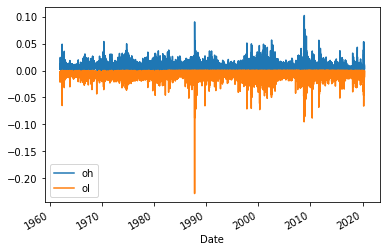

In [0]:
gspc[['oh','ol']].plot()
# gspc[['oh','ol']].add(gspc['co'],axis=0).plot()
# gspc['oc'].plot()

In [0]:
gspc.shape[0] // 20 % 20

14

In [0]:
# Creating training data structure 
x_train = []
y_train = []
for i in range( 20,gspc.shape[0] - (gspc.shape[0] // 20 % 20 )*20, 20 ):
  x_train.append(gspc.values[i-20:i,5:9])
  y_train.append(gspc.values[i+1-20:i+1,5:9])
x_train,y_train = np.array(x_train),np.array(y_train)
x_train.shape,y_train.shape

((720, 20, 4), (720, 20, 4))

In [0]:
# Creating test data structure 
x_test = []
for i in range( gspc.shape[0] - 400, gspc.shape[0] , 20 ):
  x_test.append(gspc.values[i-20:i,5:9])
x_test = np.array(x_test)
x_test.shape


(20, 20, 4)

# Model phase


In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


In [0]:
# Initializing the RNN
regressor = Sequential()

In [0]:
# adding first layer
regressor.add(LSTM(units=20, return_sequences=True, stateful=True, batch_input_shape=(20,20,4), input_shape=( x_train.shape[1],x_train.shape[2])))
regressor.add(Dropout(0.2))

In [0]:
# adding second layer
regressor.add(LSTM(units=20, return_sequences=True, stateful=True))
regressor.add(Dropout(0.2))

In [0]:
# adding third layer
regressor.add(LSTM(units=20, return_sequences=True, stateful=True))
regressor.add(Dropout(0.2))

In [0]:
# adding output layer
regressor.add(Dense( units=4 ))

In [0]:
# compile model
regressor.compile( optimizer= 'adam', loss= 'mean_squared_error')


In [0]:
regressor.fit( x_train, y_train, epochs=400, batch_size= 20 )

720/720 [==============================] - 1s 885us/step - loss: 4.5565e-05
Epoch 50/400
720/720 [==============================] - 1s 884us/step - loss: 4.5417e-05
Epoch 51/400
720/720 [==============================] - 1s 869us/step - loss: 4.5223e-05
Epoch 52/400
720/720 [==============================] - 1s 898us/step - loss: 4.5509e-05
Epoch 53/400
720/720 [==============================] - 1s 883us/step - loss: 4.5432e-05
Epoch 54/400
720/720 [==============================] - 1s 877us/step - loss: 4.5080e-05
Epoch 55/400
720/720 [==============================] - 1s 916us/step - loss: 4.5265e-05
Epoch 56/400
720/720 [==============================] - 1s 870us/step - loss: 4.5178e-05
Epoch 57/400
720/720 [==============================] - 1s 904us/step - loss: 4.5037e-05
Epoch 58/400
720/720 [==============================] - 1s 864us/step - loss: 4.5315e-05
Epoch 59/400
720/720 [==============================] - 1s 854us/step - loss: 4.5332e-05
Epoch 60/400
720/720 [============

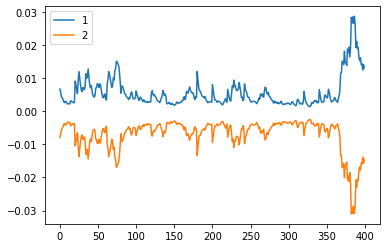

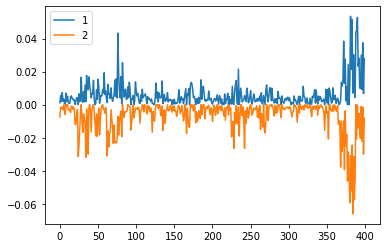

In [0]:
y_predicted = []
y_predicted = regressor.predict(x_test)
predicted = pd.DataFrame(np.reshape(y_predicted,(400,4)))
predicted.iloc[:,1:3].plot()
pd.DataFrame(np.reshape(x_test,(400,4))).iloc[:,1:3].plot()

In [0]:
x_train = np.reshape(x_train,(-1,1,4))
y_train = np.reshape(y_train,(-1,1,4))
y_train.shape

(14400, 1, 4)

In [0]:
# Initializing the RNN
regressor = Sequential()

In [0]:
# adding first layer
regressor.add(LSTM(units=20, return_sequences=True, stateful=True, batch_input_shape=(400,1,4), input_shape=( x_train.shape[1],x_train.shape[2])))
regressor.add(Dropout(0.2))

In [0]:
# adding second layer
regressor.add(LSTM(units=20, return_sequences=True, stateful=True))
regressor.add(Dropout(0.2))

In [0]:
# adding third layer
regressor.add(LSTM(units=20, return_sequences=True, stateful=True))
regressor.add(Dropout(0.2))

In [0]:
# adding output layer
regressor.add(Dense( units=4 ))

In [0]:
# compile model
regressor.compile( optimizer= 'adam', loss= 'mean_squared_error')


In [0]:
regressor.fit( x_train, y_train, epochs=400, batch_size= 400 )

Epoch 1/400
14400/14400 [==============================] - 1s 52us/step - loss: 1.1318e-04
Epoch 2/400
14400/14400 [==============================] - 0s 14us/step - loss: 1.3820e-04
Epoch 3/400
14400/14400 [==============================] - 0s 13us/step - loss: 8.4359e-05
Epoch 4/400
14400/14400 [==============================] - 0s 14us/step - loss: 6.0330e-05
Epoch 5/400
14400/14400 [==============================] - 0s 14us/step - loss: 6.0320e-05
Epoch 6/400
14400/14400 [==============================] - 0s 14us/step - loss: 6.1099e-05
Epoch 7/400
14400/14400 [==============================] - 0s 13us/step - loss: 5.7041e-05
Epoch 8/400
14400/14400 [==============================] - 0s 12us/step - loss: 5.1420e-05
Epoch 9/400
14400/14400 [==============================] - 0s 13us/step - loss: 4.9918e-05
Epoch 10/400
14400/14400 [==============================] - 0s 13us/step - loss: 4.9347e-05
Epoch 11/400
14400/14400 [==============================] - 0s 13us/step - loss: 4.9255e-

,1,2,3
0,0.005474,-0.006204,-0.000234
1,0.005033,-0.005753,-0.000283
2,0.003750,-0.004492,-0.000407
3,0.005296,-0.006005,-0.000247
4,0.004158,-0.004972,-0.000409
...,...,...,...
395,0.011474,-0.012298,0.000332
396,0.012896,-0.013754,0.000494
397,0.011659,-0.012426,0.000405
398,0.013888,-0.014755,0.000612


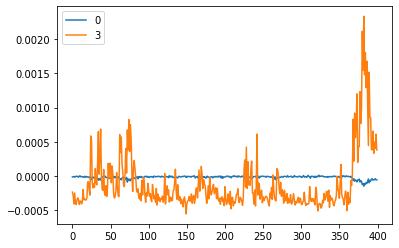

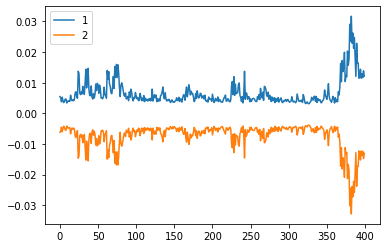

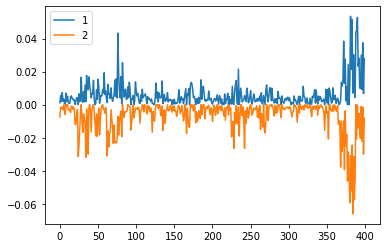

In [0]:
x_test = np.reshape(x_test,(-1,1,4))
y_predicted = []
y_predicted = regressor.predict(x_test, batch_size=400)
predicted = pd.DataFrame(np.reshape(y_predicted,(400,4)))
predicted.iloc[:,[0,3]].plot()
predicted.iloc[:,1:3].plot()
pd.DataFrame(np.reshape(x_test,(400,4))).iloc[:,1:3].plot()
predicted.iloc[:,1:4]

In [0]:
import torch
import torch.nn as nn
import torch.distributions as d

In [0]:
class Model(nn.Module):
  def __init__(self, input_size, output_size):
    super(Model, self).__init__()
    self.lstm0 = nn.LSTMCell(4,64)
    self.lstm1 = nn.LSTMCell(64,64)
    self.linear = nn.Linear(64, output_size=4)
  def forward(self, input, hidden):
    output, hidden = self.lstm0(input,hidden)
    output, hidden = self.lstm1(output, hidden)
    output = self.linear(output)
    return output

In [0]:
m = d.MultivariateNormal(torch.zeros(3), torch.eye(3))
m.sample()

tensor([-0.7860, -0.7163, -1.5673])

In [0]:
m.sample()

tensor([-1.0303, -0.7441, -0.0769])